In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('../')
import utils
import calibration_utils as calibration
import matplotlib.pyplot as plt
import scipy
import pandas as pd

In [26]:
OLD_CALIBRATION_FILE = '../input/N_matrix_trial9.mat'
CALIBRATION_FILE = '../calibration/out/cal_1_C_matrix.mat'
MEASUREMENT_ROOT = './measurement_files/'
MEASUREMENT = "cal_3"
NANO_FILE = MEASUREMENT_ROOT + MEASUREMENT + ".csv"
TELEMETRY_FILE = MEASUREMENT_ROOT + MEASUREMENT + "_telemetry.txt"

In [27]:
nano_df = calibration.nanofile_to_dataframe(NANO_FILE)
telem_df = calibration.telemetry_to_dataframe(TELEMETRY_FILE)

In [28]:
print "nano_df shape " + str(nano_df.shape)
print "telem_df shape " + str(telem_df.shape)

nano_df shape (278000, 7)
telem_df shape (20393, 9)


Plot the Fz axis force output in the nano_sensor so that you can clearly see around what time the
"flick" happened. If you can pinpoint this time and match it with the indices with both the
telemetry data and nano sensor data then this will be the alignment point for both data frames.

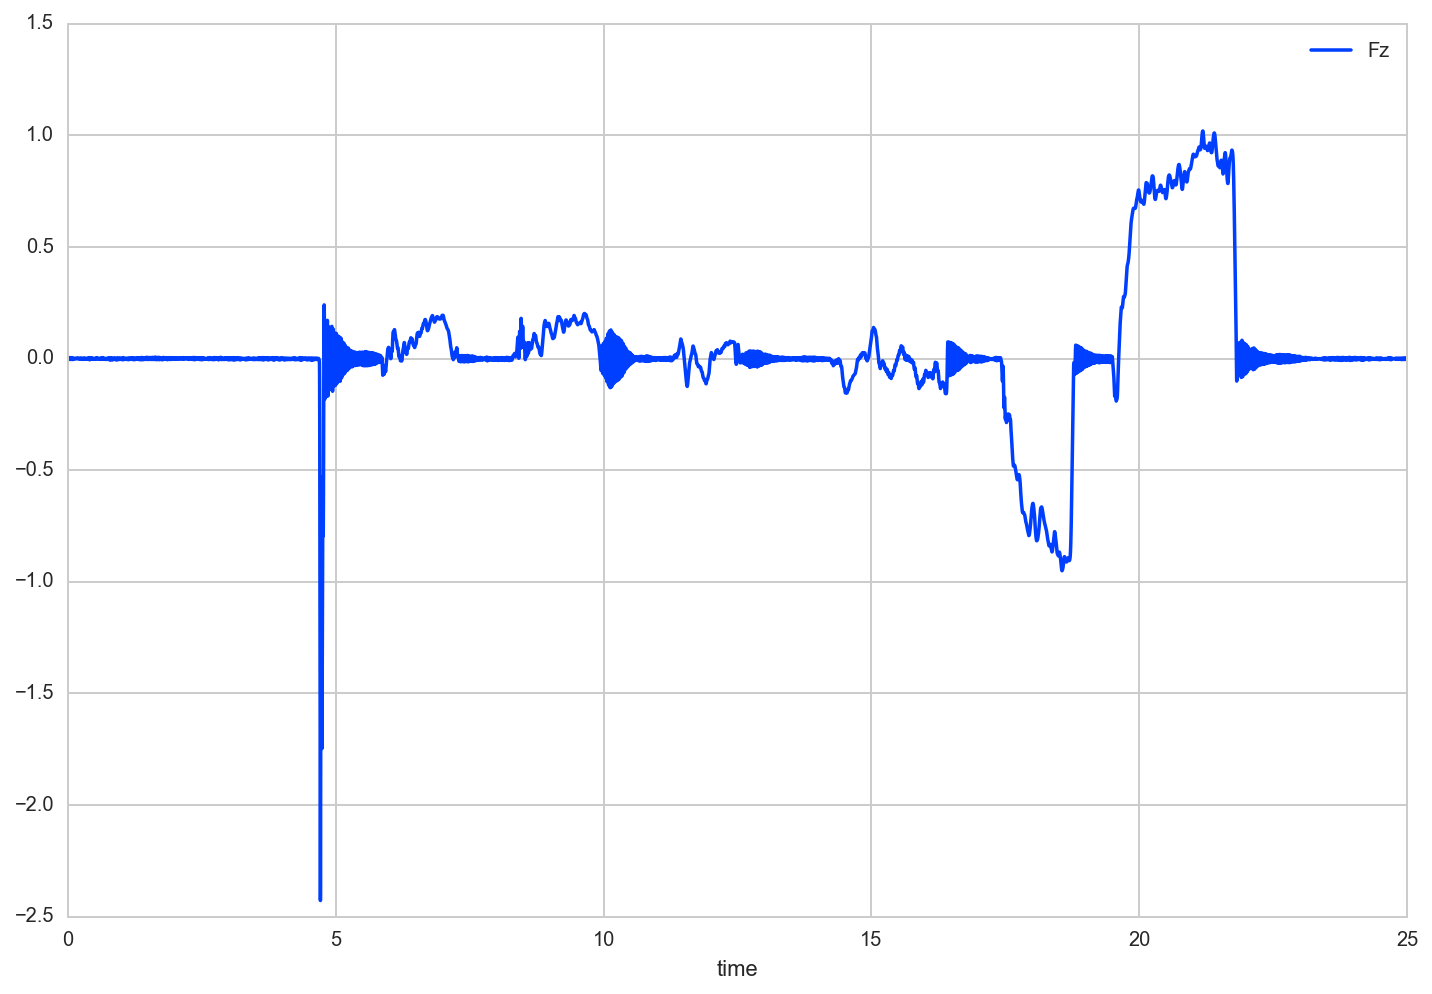

In [29]:
nano_df.plot(x="time", y="Fz", xlim=(0, 25), figsize=(12,8))
# plt.plot(nano_df["time"], nano_df["Fz"].apply(lambda x: abs(x) > 0.1))
plt.xlim((0, 25))
plt.show()

As you can see the "flick" on the shell which is the first **huge** Fz reading.
Now we need to match it with an index in nano data frame. Also will need to match it with an index in the
telemetry sensor data frame.

In [30]:
FLICK_NANO_INDEX = nano_df["Fz"][:100000].apply(abs).argmax(axis=0)
print FLICK_NANO_INDEX

47137


**Good**, now that we found the index of the "flick" in the nano sensor dataframe lets move on to finding the flick
index in the telemetry data frame. For that lets plot the telemetry data using our utils.py tools.

In [31]:
utils.print_header(TELEMETRY_FILE)
telem_force_df = utils.process_data_files(TELEMETRY_FILE, CALIBRATION_FILE)
telem_force_df.shape

%  Data file recorded 2016/7/28  11:45:36
%  Stride Frequency         = [1, 1]
%  Lead In /Lead Out        = 
%  Deltas (Fractional)      = [0.25, 0.25, 0.25],[0.25, 0.25, 0.25]
%  Phase                    = 32768
%  Experiment.py 
%  Motor Gains    = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Index([u'time', u'Right Leg Pos', u'Left Leg Pos', u'Commanded Right Leg Pos',
       u'Commanded Left Leg Pos', u'DCR', u'DCL', u'GyroX', u'GyroY', u'GyroZ',
       u'AX', u'AY', u'AZ', u'RBEMF', u'LBEMF', u'VBatt', u'S1', u'S2', u'S3',
       u'S4', u'S5', u'S6', u'S7', u'S8'],
      dtype='object')


(20393, 42)

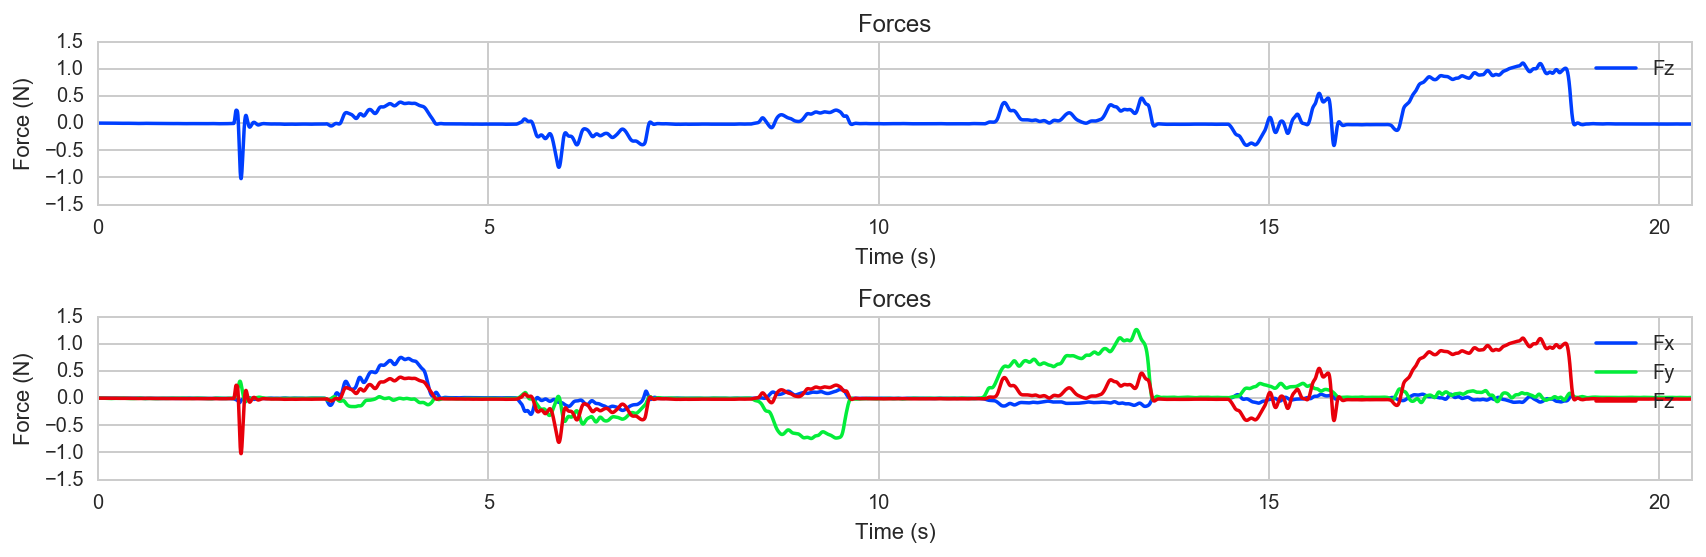

In [32]:
# utils.plot_columns(telem_force_df, [['Fx', 'Fy', 'Fz'], 'F_mag', ['Mx', 'My', 'Mz'], 'M_mag', ['AX', 'AY', 'AZ'], 'A_mag', ['GyroX', 'GyroY', 'GyroZ'], 'Gyro_mag'], display=True, save_figure=False)
utils.plot_columns(telem_force_df, ["Fz", ["Fx", "Fy", "Fz"]], display=True, save_figure=False)

**Fantastic** as you can see from the force plots the "flick" which is the first Fz force reading.

In [33]:
FLICK_TELEM_INDEX = telem_force_df['Fz'][:5000].apply(abs).argmax(axis=0) # the flick index
print "flick index in telemetry dataframe: " + str(FLICK_TELEM_INDEX)
print "flick force registered by tactile shell: " + str(telem_force_df["Fz"][FLICK_TELEM_INDEX])

flick index in telemetry dataframe: 1831
flick force registered by tactile shell: -1.02300601685


**AWESOME** Now that we have both indices in both data frames all we have to do is align them by snipping the dataframe out and only getting the rows beggining from these two indices. After this, we need to **downsample** the data stream with the higher frequency than the lower frequency data stream. Higher frequency datastream is the NANO ATI sensor stream which is at **10kHz.** The lower frequency stream is the Telemetry at **1kHz.**

In [34]:
# Downsample and Align both data frames
# M matrix is the new numpy matrix representing NANO sensor data.
# S matrix is the new numpy matrix representing TACTILE SHELL sensor data
M, S = calibration.align_two_streams(nano_df, telem_df, 10, 1, FLICK_NANO_INDEX, FLICK_TELEM_INDEX)

In [35]:
print M.shape
print S.shape

(18562, 6)
(18562, 8)


In [16]:
C = calibration.least_squares_fit(M,S)

=== S_24 shape:(18351, 24) ===
=== least squares fit DONE ===
=== C shape: (24, 6) ===


**C** is our new calibration matrix.

In [36]:
new_telemetry_force_df = utils.process_telemetry_with_C_matrix(TELEMETRY_FILE, C)
new_telemetry_force_df.shape

Index([u'time', u'Right Leg Pos', u'Left Leg Pos', u'Commanded Right Leg Pos',
       u'Commanded Left Leg Pos', u'DCR', u'DCL', u'GyroX', u'GyroY', u'GyroZ',
       u'AX', u'AY', u'AZ', u'RBEMF', u'LBEMF', u'VBatt', u'S1', u'S2', u'S3',
       u'S4', u'S5', u'S6', u'S7', u'S8'],
      dtype='object')


(20393, 42)

### Now lets plot the telemetry file data once more BUT this time using our freshly generated C calibration matrix...

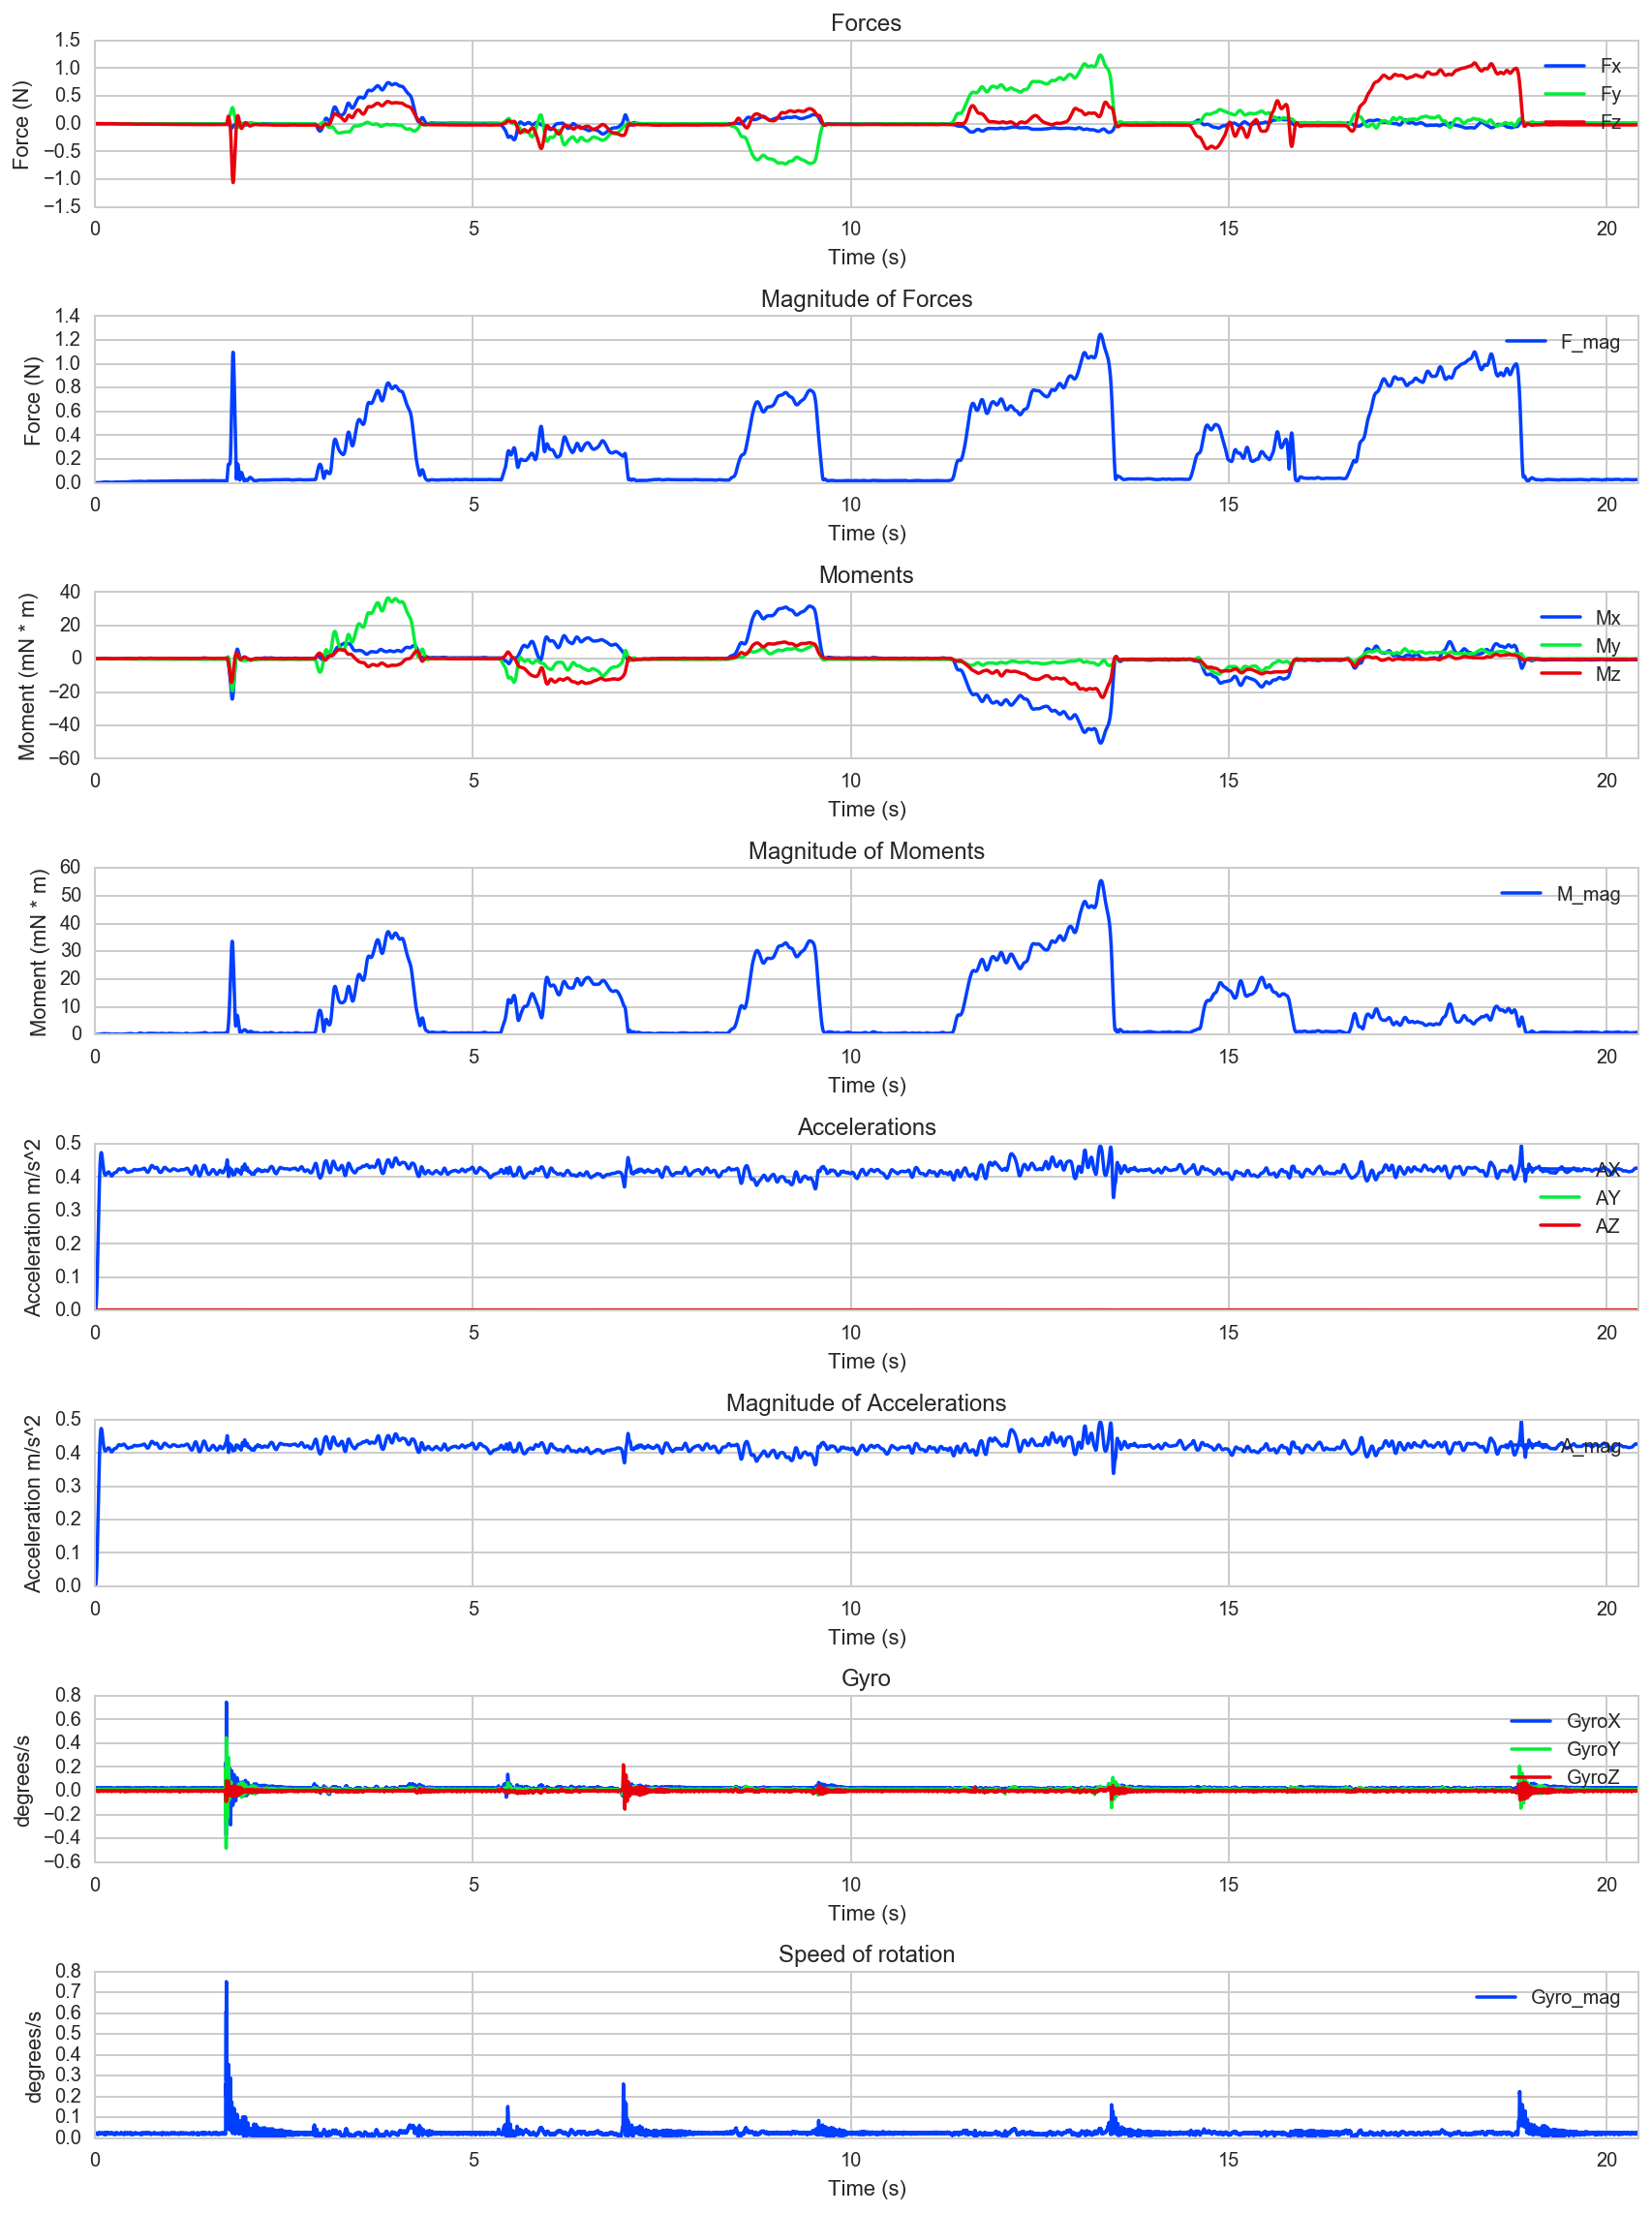

In [38]:
utils.plot_columns(new_telemetry_force_df, [['Fx', 'Fy', 'Fz'], 'F_mag', ['Mx', 'My', 'Mz'], 'M_mag', ['AX', 'AY', 'AZ'], 'A_mag', ['GyroX', 'GyroY', 'GyroZ'], 'Gyro_mag'], display=True, save_figure=False)

Now lets compare the calibration matrix accuracy by getting NANO sensor Fz at the "flick" and by getting tactile sensor force data "Fz" at the "flick".

#### ATI Nano Sensor Fz Reading

In [39]:
nano_df["Fz"][FLICK_NANO_INDEX]

-2.4279099999999998

#### Tactile Shell Fz Reading Using Calibration Matrix: C

In [40]:
new_telemetry_force_df["Fz"][FLICK_TELEM_INDEX]

-1.0437055474751207

Save the calibration matrix to a .mat file.

In [41]:
# scipy.io.savemat("./out/" + MEASUREMENT + "_C_matrix.mat", {"C":C})